# In this particular session, we will build different ARIMA models on the Training Data and then go on to check the accuracy (or error) on the training and test data. The model which performs the best on the test data is an optimum model for us.

# Case Study - We are going to analyse and predict Sales of a particular brick and mortar retail store. The data that we have ranges from 2000 to 2015.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme(style='darkgrid')
import warnings
warnings.filterwarnings('ignore')

## Read the data

In [2]:
df = pd.read_csv('Sales.csv')
df.head()

,RetailSales
0,2585
1,3368
2,3210
3,3111
4,3756


## Convert to Time Series Format

In [3]:
len(df) # observations for 15 years and 7 months

187

In [4]:
date = pd.date_range(start='1/1/2000', periods=len(df), freq='M')
date

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2014-10-31', '2014-11-30', '2014-12-31', '2015-01-31',
               '2015-02-28', '2015-03-31', '2015-04-30', '2015-05-31',
               '2015-06-30', '2015-07-31'],
              dtype='datetime64[ns]', length=187, freq='M')

In [5]:
# Adding the time stamp to the data frame
df['Time_Stamp'] = date
df.head()

,RetailSales,Time_Stamp
0,2585,2000-01-31
1,3368,2000-02-29
2,3210,2000-03-31
3,3111,2000-04-30
4,3756,2000-05-31


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   RetailSales  187 non-null    int64         
 1   Time_Stamp   187 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.0 KB


In [7]:
# Set the Time_Stamp column as the index of the dataframe
df.set_index('Time_Stamp',inplace=True)
df.head()

,RetailSales
Time_Stamp,
2000-01-31,2585
2000-02-29,3368
2000-03-31,3210
2000-04-30,3111
2000-05-31,3756


In [8]:
df.index.freq = 'M' # to avoid the warning messages when fitting the ARIMA/SARIMA models

## Plot the Time Series

In [9]:
# The following code is to set the figure sizes for all subsequent plots in the notebook

from pylab import rcParams
rcParams['figure.figsize'] = 20,8

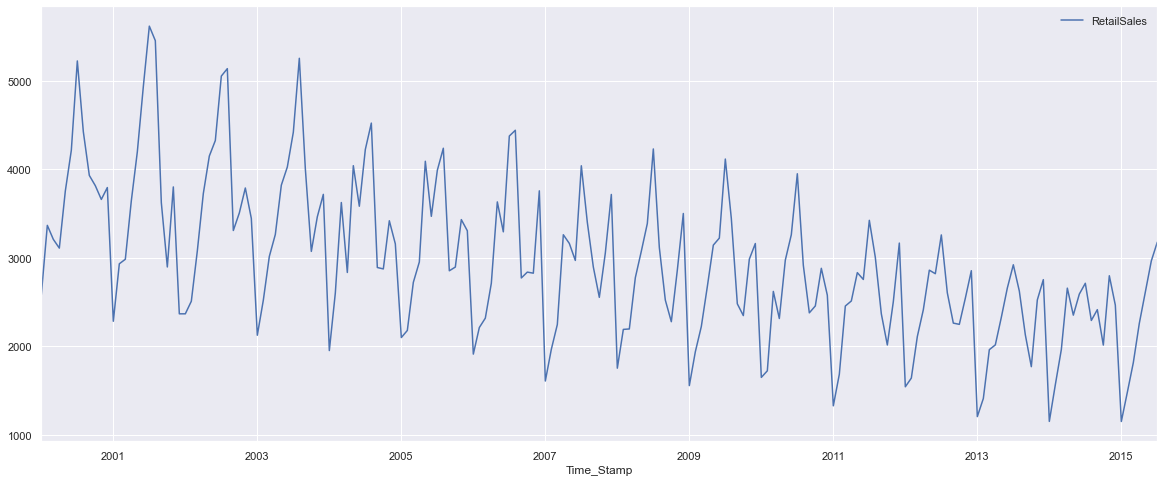

In [10]:
df.plot()
plt.grid(True);

We can see that there is a slight downward trend with a seasonal pattern associated as well.

## Basic Descriptive statistics

In [12]:
df.describe().round(0)

,RetailSales
count,187.0
mean,2962.0
std,879.0
min,1153.0
25%,2362.0
50%,2876.0
75%,3468.0
max,5618.0


The basic measures of descriptive statistics tell us how the Sales have varied across years. But remember, for this measure of descriptive statistics we have averaged over the whole data without taking the time component into account.

## Boxplots - Sales across years & within months across years.

### Yearly Boxplot

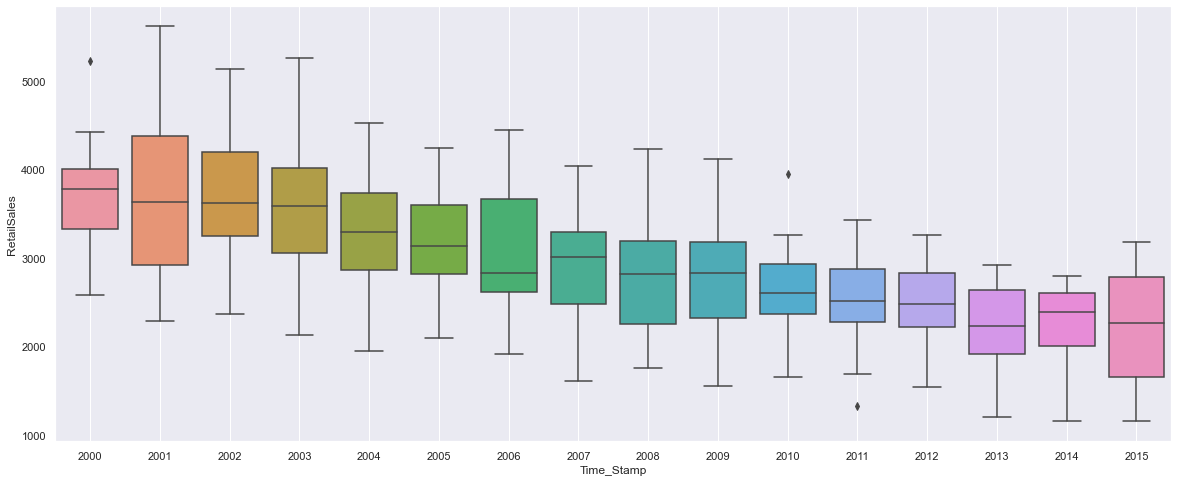

In [13]:
sns.boxplot(x = df.index.year,
            y = df['RetailSales'],
            notch=False)
plt.grid();

The yearly boxplots also shows that the Sales have decreased towards the last few years.

### Monthly Plot

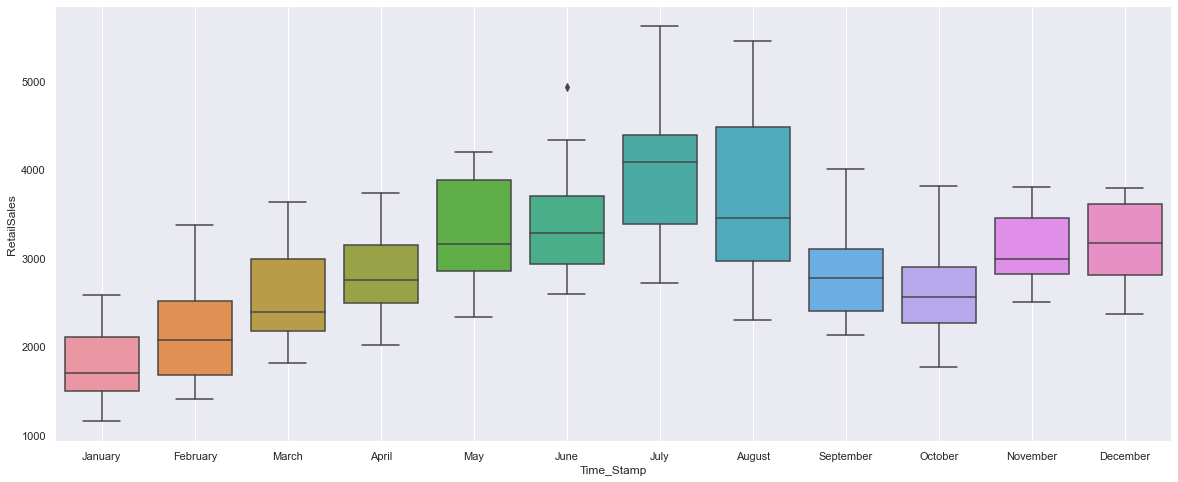

In [14]:
sns.boxplot(x = df.index.month_name(),
            y = df['RetailSales'], 
            notch=False)
plt.grid();

There is a clear distinction of 'RetailSales' within different months spread across various years. The highest such numbers are being recorded in the month of July-August across various years.

## Time seres monthplot - spread of sales across years & within months across years

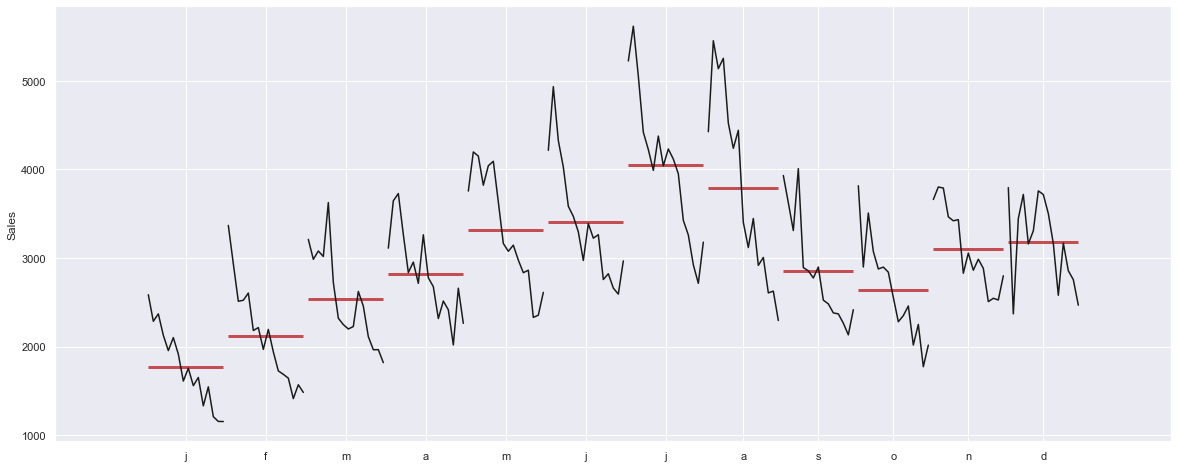

In [15]:
from statsmodels.graphics.tsaplots import month_plot

month_plot(df['RetailSales'],ylabel='Sales')
plt.grid(True);

This plot shows us the behaviour of the Time Series ('RetailSales' in this case) across various months. The red line is the median value.

## Plot of monthly RetailSales across years

In [16]:
monthly_sales_across_years = pd.pivot_table(df, values = 'RetailSales', columns = df.index.month, index = df.index.year)
monthly_sales_across_years

Time_Stamp,1,2,3,4,5,6,7,8,9,10,11,12
Time_Stamp,,,,,,,,,,,,
2000,2585.0,3368.0,3210.0,3111.0,3756.0,4216.0,5225.0,4426.0,3932.0,3816.0,3661.0,3795.0
2001,2285.0,2934.0,2985.0,3646.0,4198.0,4935.0,5618.0,5454.0,3624.0,2898.0,3802.0,2369.0
2002,2369.0,2511.0,3079.0,3728.0,4151.0,4326.0,5054.0,5138.0,3310.0,3508.0,3790.0,3446.0
2003,2127.0,2523.0,3017.0,3265.0,3822.0,4027.0,4420.0,5255.0,4009.0,3074.0,3465.0,3718.0
2004,1954.0,2604.0,3626.0,2836.0,4042.0,3584.0,4225.0,4523.0,2892.0,2876.0,3420.0,3159.0
2005,2101.0,2181.0,2724.0,2954.0,4092.0,3470.0,3990.0,4239.0,2855.0,2897.0,3433.0,3307.0
2006,1914.0,2214.0,2320.0,2714.0,3633.0,3295.0,4377.0,4442.0,2774.0,2840.0,2828.0,3758.0
2007,1610.0,1968.0,2248.0,3262.0,3164.0,2972.0,4041.0,3402.0,2898.0,2555.0,3056.0,3717.0
2008,1755.0,2193.0,2198.0,2777.0,3076.0,3389.0,4231.0,3118.0,2524.0,2280.0,2862.0,3502.0


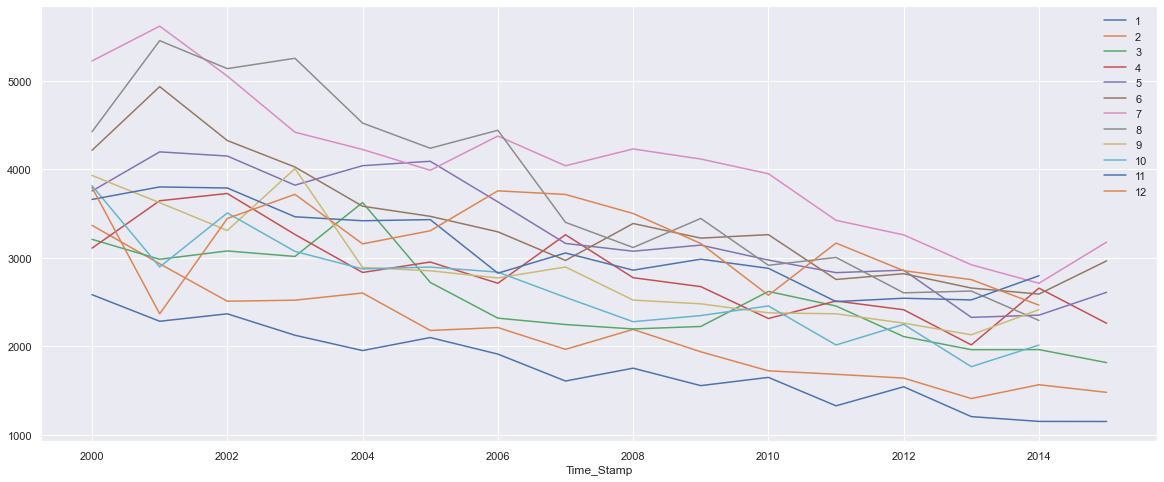

In [17]:
monthly_sales_across_years.plot()
plt.grid(True)
plt.legend(loc='best');

## Plot Empirical Cumulative Distribution of Sales

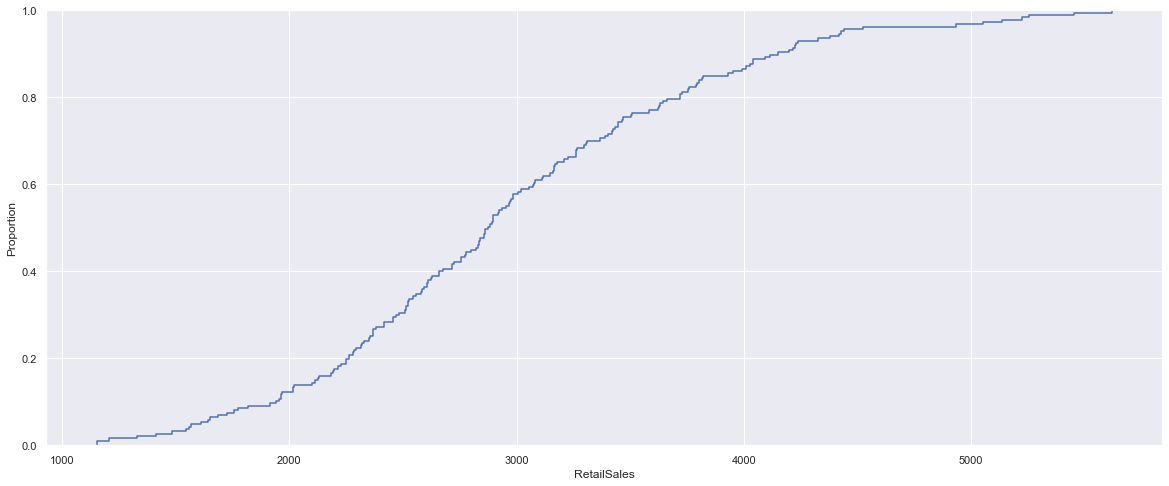

In [18]:
# Percentile Distribution of Sales values

sns.ecdfplot(df['RetailSales']);
plt.grid(True);

In [ ]:
# Alternate method of plotting ECDF Plot

# from statsmodels.distributions.empirical_distribution import ECDF

# plt.figure(figsize = (18, 8))
# cdf = ECDF(df['RetailSales'])
# plt.plot(cdf.x, cdf.y, label = "statmodels");
# plt.grid()
# plt.xlabel('Sales');

This particular graph tells us what percentage of data points refer to what number of Sales.

## Plot month on month % change of RetailSales

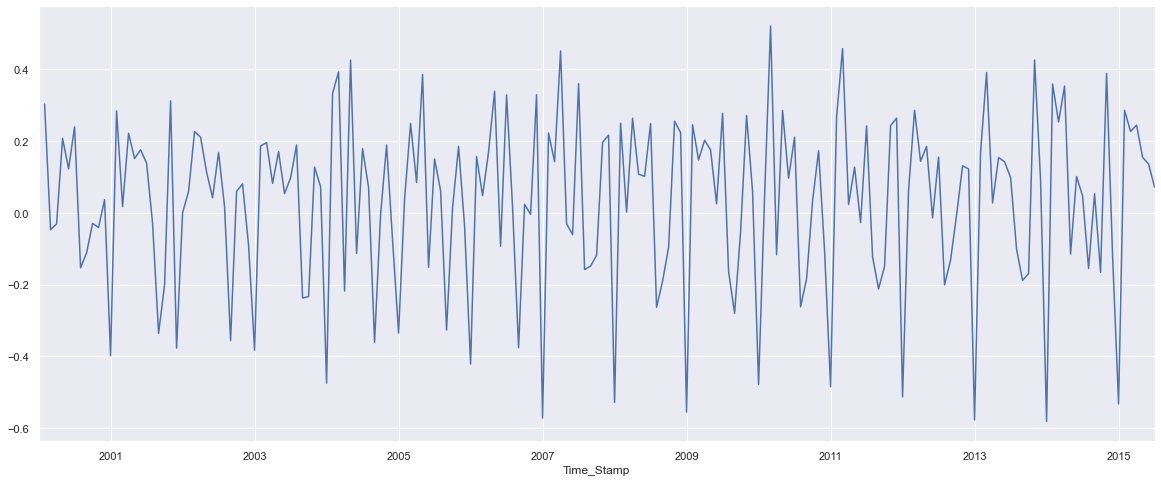

In [19]:
pct_change = df["RetailSales"].pct_change()

pct_change.plot();

The above two graph shows us the Percentage change of 'RetailSales' with respect to the time. It varies from 50% on the positive side to 50% on the negative side compared to the previous month.

## Decompose Time Series  components.

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

### Additive Decomposition

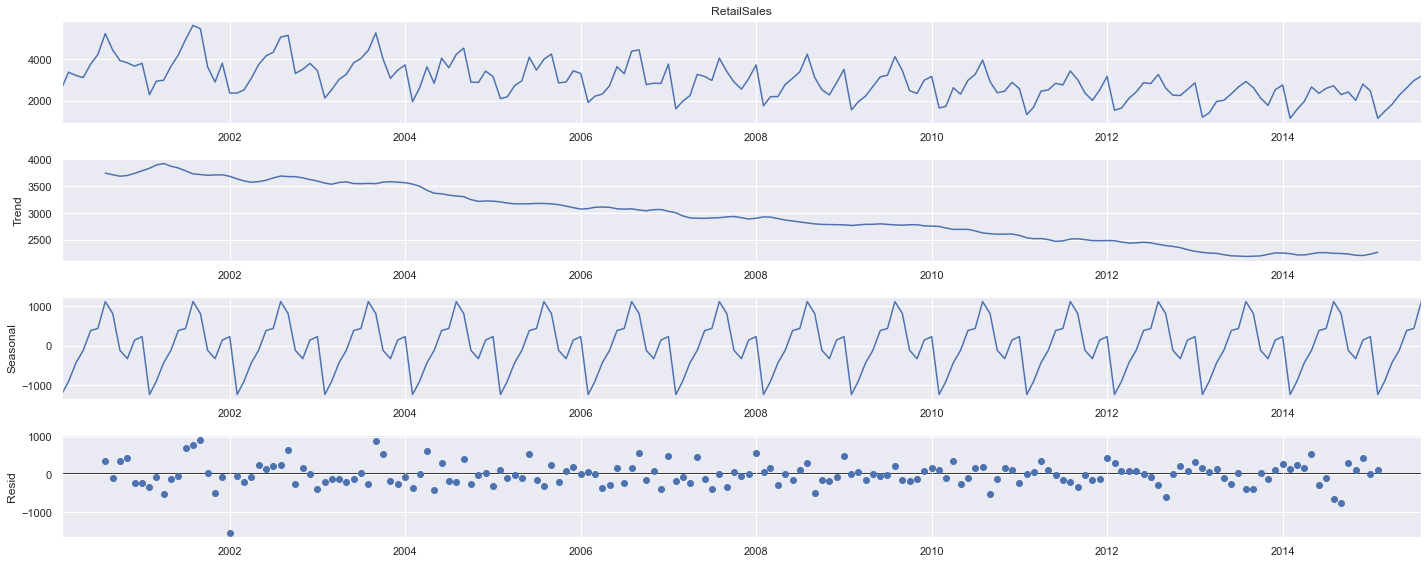

In [21]:
decomposition = seasonal_decompose(df['RetailSales'],model='additive')
decomposition.plot();

We see that the residuals are randomly located around 0 from the plot of the residuals in the decomposition to begin with but towards the later years we can see some patterns. This may be due to the decrease in seasonal peak heights towards the later years thereby indicating multiplicative seasonality towards the end.

In [22]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 Time_Stamp
2000-01-31            NaN
2000-02-29            NaN
2000-03-31            NaN
2000-04-30            NaN
2000-05-31            NaN
2000-06-30            NaN
2000-07-31    3745.916667
2000-08-31    3715.333333
2000-09-30    3687.875000
2000-10-31    3700.791667
2000-11-30    3741.500000
2000-12-31    3789.875000
Freq: M, Name: trend, dtype: float64 

Seasonality 
 Time_Stamp
2000-01-31   -1230.608333
2000-02-29    -900.364286
2000-03-31    -429.435714
2000-04-30    -116.923810
2000-05-31     383.713095
2000-06-30     435.802381
2000-07-31    1113.975000
2000-08-31     811.258333
2000-09-30    -115.036111
2000-10-31    -325.811111
2000-11-30     143.525000
2000-12-31     229.905556
Freq: M, Name: seasonal, dtype: float64 

Residual 
 Time_Stamp
2000-01-31           NaN
2000-02-29           NaN
2000-03-31           NaN
2000-04-30           NaN
2000-05-31           NaN
2000-06-30           NaN
2000-07-31    365.108333
2000-08-31   -100.591667
2000-09-30    359.161111
2000

### Multiplicative Decomposition

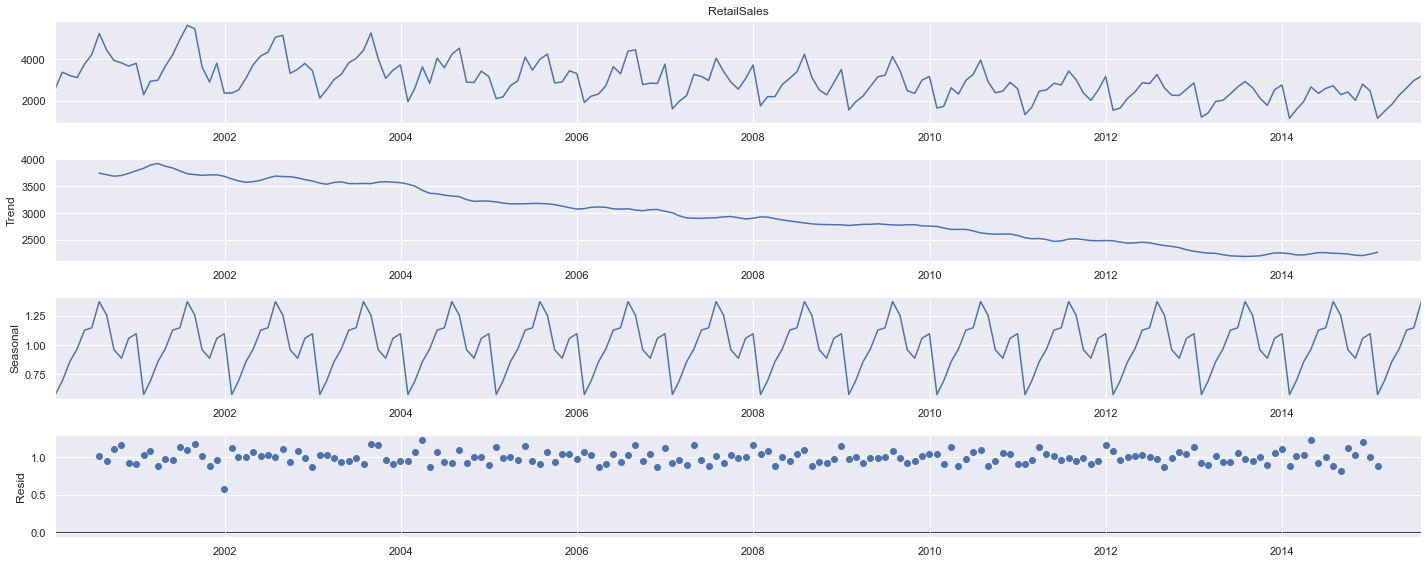

In [23]:
decomposition = seasonal_decompose(df['RetailSales'],model='multiplicative')
decomposition.plot();

For the multiplicative series, we see that a lot of residuals are located around 1.

In [24]:
trend = decomposition.trend
seasonality = decomposition.seasonal
residual = decomposition.resid

print('Trend','\n',trend.head(12),'\n')
print('Seasonality','\n',seasonality.head(12),'\n')
print('Residual','\n',residual.head(12),'\n')

Trend 
 Time_Stamp
2000-01-31            NaN
2000-02-29            NaN
2000-03-31            NaN
2000-04-30            NaN
2000-05-31            NaN
2000-06-30            NaN
2000-07-31    3745.916667
2000-08-31    3715.333333
2000-09-30    3687.875000
2000-10-31    3700.791667
2000-11-30    3741.500000
2000-12-31    3789.875000
Freq: M, Name: trend, dtype: float64 

Seasonality 
 Time_Stamp
2000-01-31    0.577667
2000-02-29    0.693995
2000-03-31    0.858591
2000-04-30    0.965907
2000-05-31    1.127574
2000-06-30    1.147570
2000-07-31    1.371537
2000-08-31    1.254060
2000-09-30    0.960255
2000-10-31    0.887973
2000-11-30    1.057467
2000-12-31    1.097405
Freq: M, Name: seasonal, dtype: float64 

Residual 
 Time_Stamp
2000-01-31         NaN
2000-02-29         NaN
2000-03-31         NaN
2000-04-30         NaN
2000-05-31         NaN
2000-06-30         NaN
2000-07-31    1.017000
2000-08-31    0.949938
2000-09-30    1.110327
2000-10-31    1.161218
2000-11-30    0.925310
2000-12-31  

## Check for stationarity of the whole Time Series data.

In [25]:
## Test for stationarity of the series - Dicky Fuller test

from statsmodels.tsa.stattools import adfuller    

In [ ]:
# help(adfuller)

In [27]:
adfuller(df['RetailSales'])[1] # extracting the relevant output --> p-value, which is at the 2nd index position in the output

# Ho : There is no stationarity

0.7855322305097688

In [28]:
# Perform Dickey-Fuller test: Ho : There is no stationarity
# If test DF test statistic is less than the critical value or if pvalue < 0.05 --> reject Ho 

# Formatting the output

print ('Results of Dickey-Fuller Test:')
dftest = adfuller(df['RetailSales'])

dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

print (dfoutput,'\n')

Results of Dickey-Fuller Test:
Test Statistic                  -0.907380
p-value                          0.785532
#Lags Used                      11.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64 



We see that at 5% significant level the Time Series is non-stationary as at high p-value we are unable to reject the null hypothesis.

Let us take a difference of order 1 and check whether the Time Series is stationary or not.

In [29]:
df['RetailSales'].diff()

Time_Stamp
2000-01-31      NaN
2000-02-29    783.0
2000-03-31   -158.0
2000-04-30    -99.0
2000-05-31    645.0
              ...  
2015-03-31    336.0
2015-04-30    444.0
2015-05-31    350.0
2015-06-30    355.0
2015-07-31    212.0
Freq: M, Name: RetailSales, Length: 187, dtype: float64

In [30]:
adfuller(df['RetailSales'].diff().dropna())[1] # d -->1

0.0

We see that at $\alpha$ = 0.05 the Time Series is indeed stationary as the p-value is lower than 0.05 and hence we can reject the null hypothesis which says that the time series is not stationary. So differentiation by 1 makes the time series stationary.

## Autocorrelation & Partial Autocorrelation function

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

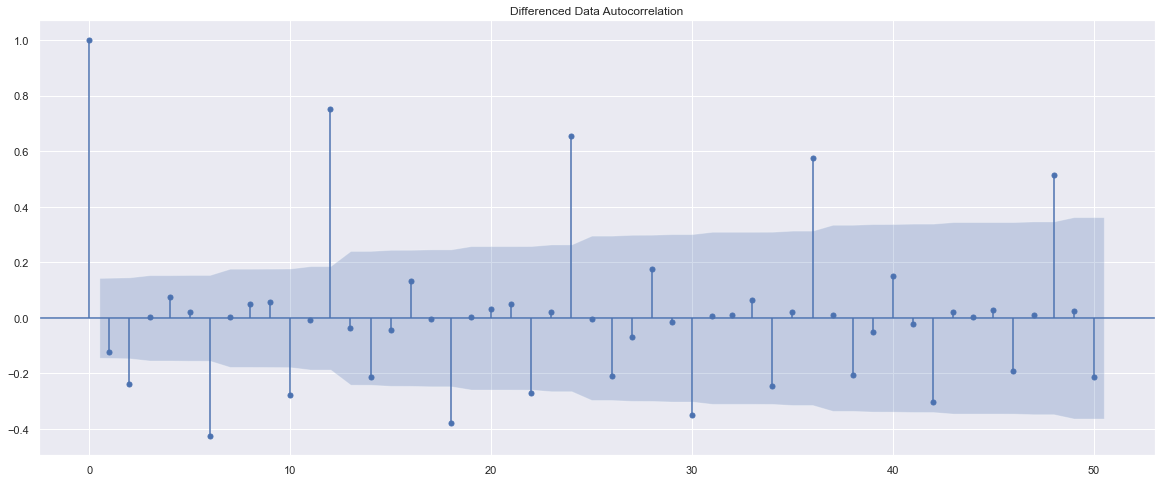

In [32]:
plot_acf(df['RetailSales'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation');

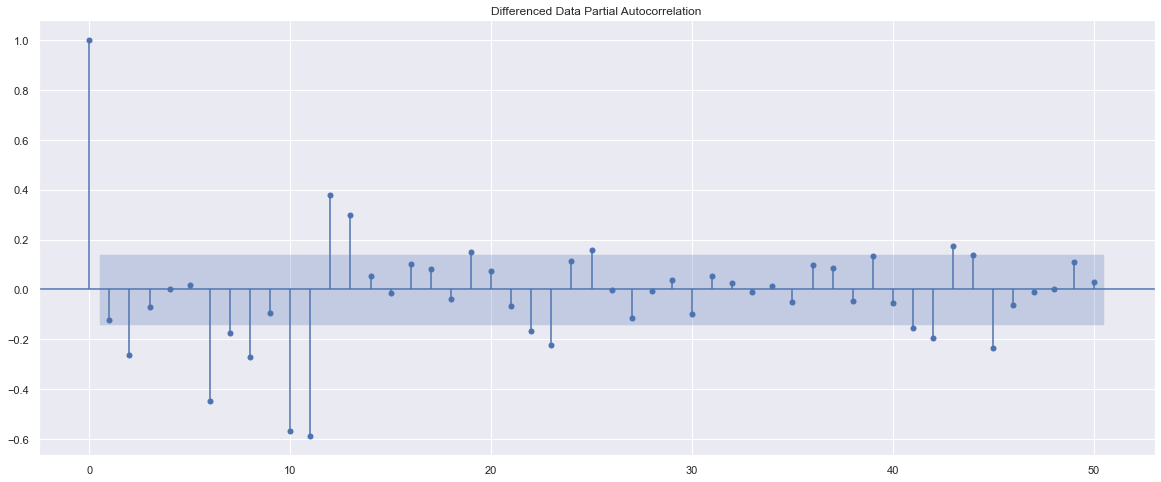

In [33]:
plot_pacf(df['RetailSales'].diff().dropna(),lags=50,title='Differenced Data Partial Autocorrelation');

From the above plots, we can say that there seems to be a seasonality in the data as there are significant correlations at multiples of 6 and 12 lags.

## Train & Test Data Split & Plot

Training Data is till the end of 2010. Test Data is from the beginning of 2011 to the last time stamp provided.

In [34]:
train=df[df.index.year < 2011]
test=df[df.index.year >= 2011]

In [35]:
## This is to display multiple data frames from one code cell
from IPython.display import display

In [36]:
print('First few rows of Training Data')
display(train.head())
print('Last few rows of Training Data')
display(train.tail())
print('First few rows of Test Data')
display(test.head())
print('Last few rows of Test Data')
display(test.tail())

First few rows of Training Data


,RetailSales
Time_Stamp,
2000-01-31,2585
2000-02-29,3368
2000-03-31,3210
2000-04-30,3111
2000-05-31,3756


Last few rows of Training Data


,RetailSales
Time_Stamp,
2010-08-31,2917
2010-09-30,2380
2010-10-31,2458
2010-11-30,2883
2010-12-31,2579


First few rows of Test Data


,RetailSales
Time_Stamp,
2011-01-31,1330
2011-02-28,1686
2011-03-31,2457
2011-04-30,2514
2011-05-31,2834


Last few rows of Test Data


,RetailSales
Time_Stamp,
2015-03-31,1818
2015-04-30,2262
2015-05-31,2612
2015-06-30,2967
2015-07-31,3179


In [37]:
print(train.shape)
print(test.shape)

(132, 1)
(55, 1)


## Check for stationarity of the Training Data Time Series.

In [38]:
adfuller(train['RetailSales'])[1] # gives p-value

0.9132573679129727

We see that the series is not stationary at $\alpha$ = 0.05.

In [39]:
adfuller(train['RetailSales'].diff().dropna())[1]

0.0

We see that after taking a difference of order 1 the series have become stationary at $\alpha$ = 0.05.

 Note: If the series is non-stationary, stationarize the Time Series by taking a difference of the Time Series. Then we can use this particular differenced series to train the ARIMA models. We do not need to worry about stationarity for the Test Data because we are not building any models on the Test Data, we are evaluating our models over there. You can look at other kinds of transformations as part of making the time series stationary like taking logarithms.

## Automated version of an ARIMA model : Based on lowest Akaike Information Criteria (AIC).

<p style= "color:red; font-weight:bold;background:gold">Note: The data has some seasonality so ideally we should build a SARIMA model. But for demonstration purposes we are building an ARIMA model both automatically, by looking at the minimum AIC criterion and manually, by looking at the ACF and the PACF plots.</p>

In [40]:
## The following loop helps us in getting a combination of different parameters of p and q in the range of 0 and 2
## We have kept the value of d as 1 as we already know that we need to take a first order difference of the series to make it stationary.

import itertools # library for generating all possible combinations of given number sets
p = q = range(0, 3)
d= range(1,2) # required as itertools product function expects the parameters as range objects, even if it is only value

pdq = list(itertools.product(p, d, q))

print('Some parameter combinations for the Model...')
for i in range(0,len(pdq)):
    print(f'Model: {pdq[i]}')

Some parameter combinations for the Model...
Model: (0, 1, 0)
Model: (0, 1, 1)
Model: (0, 1, 2)
Model: (1, 1, 0)
Model: (1, 1, 1)
Model: (1, 1, 2)
Model: (2, 1, 0)
Model: (2, 1, 1)
Model: (2, 1, 2)


In [41]:
# Creating an empty Dataframe with column names only
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

,param,AIC


In [42]:
from statsmodels.tsa.arima_model import ARIMA

In [43]:
for param in pdq:
    ARIMA_model = ARIMA(train['RetailSales'],
                        order=param).fit()
    
    print(f'ARIMA{param} - AIC:{ARIMA_model.aic}')
    
    ARIMA_AIC=ARIMA_AIC.append({'param':param, 
                                'AIC': ARIMA_model.aic},
                               ignore_index=True)

ARIMA(0, 1, 0) - AIC:2118.915581713951
ARIMA(0, 1, 1) - AIC:2116.842560408146
ARIMA(0, 1, 2) - AIC:2088.8323982197476
ARIMA(1, 1, 0) - AIC:2118.6460757420773
ARIMA(1, 1, 1) - AIC:2089.6094605368635
ARIMA(1, 1, 2) - AIC:2088.6286736476936
ARIMA(2, 1, 0) - AIC:2113.4559523066964
ARIMA(2, 1, 1) - AIC:2088.5513567082808
ARIMA(2, 1, 2) - AIC:2088.76116219612


In [44]:
ARIMA_AIC

,param,AIC
0,"(0, 1, 0)",2118.915582
1,"(0, 1, 1)",2116.842560
2,"(0, 1, 2)",2088.832398
3,"(1, 1, 0)",2118.646076
4,"(1, 1, 1)",2089.609461
5,"(1, 1, 2)",2088.628674
6,"(2, 1, 0)",2113.455952
7,"(2, 1, 1)",2088.551357
8,"(2, 1, 2)",2088.761162


In [45]:
## Sort the above AIC values in the ascending order to get the parameters for the minimum AIC value

ARIMA_AIC.sort_values(by='AIC',ascending=True)

,param,AIC
7,"(2, 1, 1)",2088.551357
5,"(1, 1, 2)",2088.628674
8,"(2, 1, 2)",2088.761162
2,"(0, 1, 2)",2088.832398
4,"(1, 1, 1)",2089.609461
6,"(2, 1, 0)",2113.455952
1,"(0, 1, 1)",2116.842560
3,"(1, 1, 0)",2118.646076
0,"(0, 1, 0)",2118.915582


In [46]:
auto_ARIMA = ARIMA(train['RetailSales'], order=(2,1,1),freq='M')

results_auto_ARIMA = auto_ARIMA.fit()

results_auto_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.RetailSales   No. Observations:                  131
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1039.276
Method:                       css-mle   S.D. of innovations            664.314
Date:                Sat, 29 Jan 2022   AIC                           2088.551
Time:                        10:19:19   BIC                           2102.927
Sample:                    02-29-2000   HQIC                          2094.393
                         - 12-31-2010                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -9.1739      2.615     -3.508      0.000     -14.299      -4.049
ar.L1.D.RetailSales     0.5782      0.087      6.650      0.000       0.408       0.749
ar.L2.D.RetailSales    -0.1529      0.087     -1.762      0.078      -0.323       0.017
ma.L1.D.RetailSales    -1.0000      0.020    -50.991      0.000      -1.038      -0.962
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.8904           -1.7220j            2.5571           -0.1176
AR.2            1.8904           +1.7220j            2.5571            0.1176
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

## Predict on the Test Set & Evaluation - Auto Arima Model

In [48]:
predicted_auto_ARIMA = results_auto_ARIMA.forecast(steps=len(test))

In [49]:
predicted_auto_ARIMA

(array([2549.28651589, 2573.3240947 , 2586.49444673, 2585.16115207,
        2577.10365225, 2567.37619948, 2557.71149637, 2548.33846087,
        2539.12447365, 2529.95784482, 2520.7942758 , 2511.6252335 ,
        2502.45255856, 2493.27862023, 2484.10450694, 2474.93048569,
        2465.75654441, 2456.5826353 , 2447.40873257, 2438.23482859,
        2429.06092293, 2419.88701647, 2410.71310982, 2401.53920318,
        2392.36529657, 2383.19138998, 2374.0174834 , 2364.84357681,
        2355.66967023, 2346.49576364, 2337.32185706, 2328.14795047,
        2318.97404389, 2309.8001373 , 2300.62623072, 2291.45232413,
        2282.27841754, 2273.10451096, 2263.93060437, 2254.75669779,
        2245.5827912 , 2236.40888462, 2227.23497803, 2218.06107145,
        2208.88716486, 2199.71325827, 2190.53935169, 2181.3654451 ,
        2172.19153852, 2163.01763193, 2153.84372535, 2144.66981876,
        2135.49591218, 2126.32200559, 2117.14809901]),
 array([664.31373368, 767.37734259, 776.78550002, 776.8628853

predicted_auto_ARIMA is a tuple consisting of the predicted mean values, standard deviation of predictions and the confidence interval of the predictions

In [51]:
# from sklearn.metrics import  mean_squared_error --> alternate method
from statsmodels.tools.eval_measures import rmse

# predicted_auto_ARIMA[0] contains the predictions(mean values)
RMSE_autoarima = rmse(test['RetailSales'],predicted_auto_ARIMA[0])
print(RMSE_autoarima)

564.1018841353572


In [52]:
resultsDf = pd.DataFrame({'RMSE': [RMSE_autoarima]}
                           ,index=['ARIMA(2,1,1)'])

resultsDf

,RMSE
"ARIMA(2,1,1)",564.101884


## Manual ARIMA model - Using ACF  & PACF plots

Let us look at the ACF and the PACF plots once more.

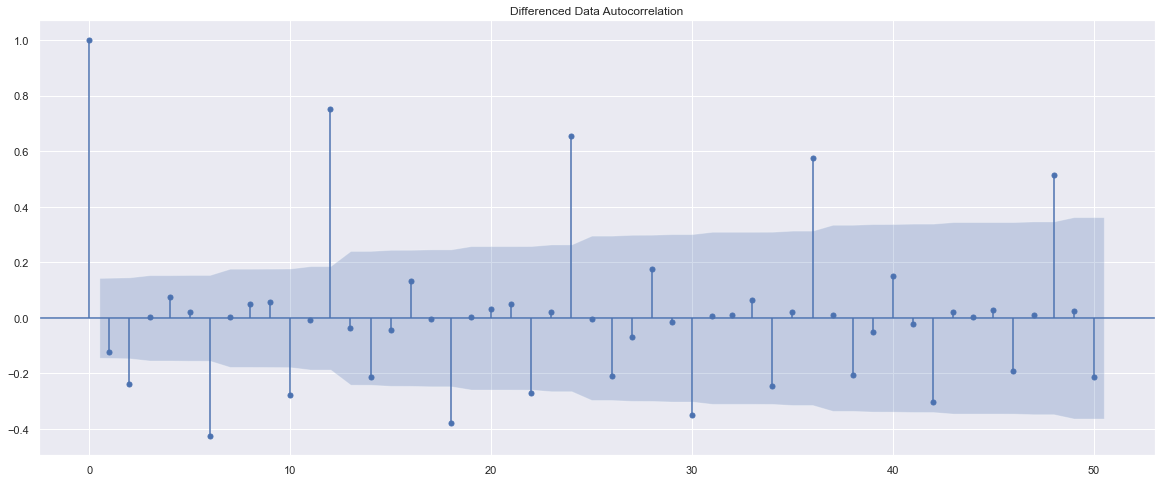

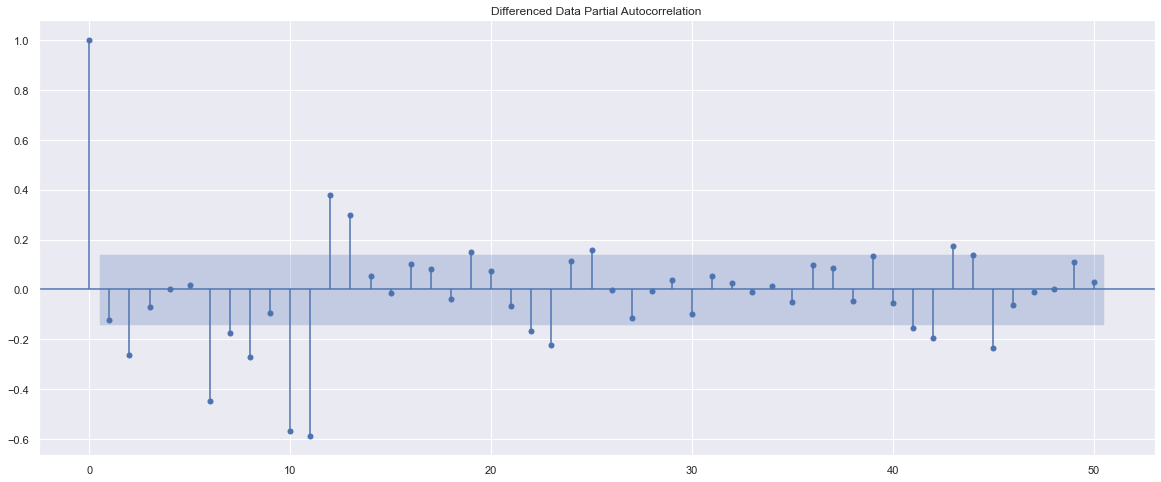

In [53]:
plot_acf(df['RetailSales'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation');
plot_pacf(df['RetailSales'].diff().dropna(),lags=50,title='Differenced Data Partial Autocorrelation');

Here, we have taken alpha=0.05.

* The Auto-Regressive parameter in an ARIMA model is 'p' which comes from the significant lag before which the PACF plot cuts-off to 0.
* The Moving-Average parameter in an ARIMA model is 'q' which comes from the significant lag before the ACF plot cuts-off to 0.

By looking at the above plots, we can say that both the PACF and ACF plot cuts-off at lag 0. So,our pdq values are 0,1,0.

In [54]:
manual_ARIMA = ARIMA(train['RetailSales'].astype('float64'), order=(0,1,0),freq='M')

results_manual_ARIMA = manual_ARIMA.fit()

results_manual_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:          D.RetailSales   No. Observations:                  131
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1057.458
Method:                           css   S.D. of innovations            775.306
Date:                Sat, 29 Jan 2022   AIC                           2118.916
Time:                        10:35:20   BIC                           2124.666
Sample:                    02-29-2000   HQIC                          2121.252
                         - 12-31-2010                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0458     67.739     -0.001      0.999    -132.811     132.720
==============================================================================
"""

We get a comparatively simpler model by looking at the ACF and the PACF plots.

<p style = {color:"red" ! important;}>Note: When we see that both the AR(p) and the MA(q) model are of order 0, we have to convert the input variable into a 'float64' type variable else Python might throw an error when we try to forecast </p>

## Predict on the Test Set & Evaluation

In [55]:
predicted_manual_ARIMA = results_manual_ARIMA.forecast(steps=len(test))

In [56]:
from statsmodels.tools.eval_measures import rmse
RMSE_manualarima = rmse(test['RetailSales'],
                        predicted_manual_ARIMA[0])
RMSE_manualarima

611.2873440695147

In [57]:
temp_resultsDf = pd.DataFrame({'RMSE': [RMSE_manualarima]}
                           ,index=['ARIMA(0,1,0)'])


resultsDf = pd.concat([resultsDf,temp_resultsDf])

resultsDf

,RMSE
"ARIMA(2,1,1)",564.101884
"ARIMA(0,1,0)",611.287344


We see that there is difference in the RMSE values for both the models, but remember that the second model is a much simpler model.

## Automated version of a SARIMA model -Parameter Selection with lowest Akaike Information Criteria (AIC).

Let us look at the ACF plot once more to understand the seasonal parameters PDQ for the SARIMA model.

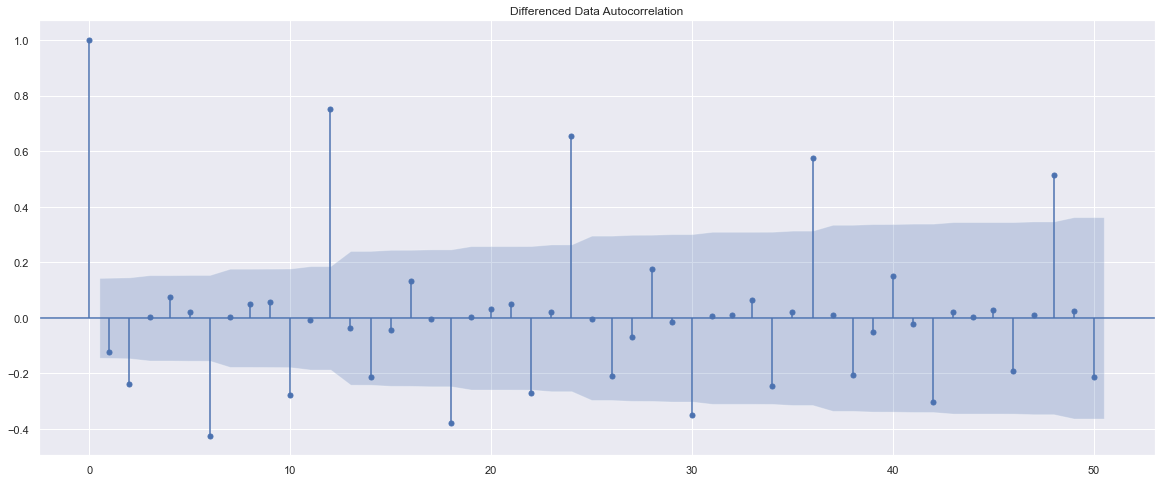

In [58]:
plot_acf(df['RetailSales'].diff().dropna(),lags=50,title='Differenced Data Autocorrelation');

We see that there can be a seasonality of 6 as well as 12. We will run our auto SARIMA models by setting seasonality both as 6 and 12.

### Auto SARIMA model - With Seasonality as 6

In [59]:
import itertools
p = q = range(0, 3)
d= range(1,2)
D = range(0,1)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, D, q))] # seasonal PDQ
print('Examples of some parameter combinations for Model...')
for i in range(0,len(pdq)):
    print(f'Model: {pdq[i]}{model_pdq[i]}')

Examples of some parameter combinations for Model...
Model: (0, 1, 0)(0, 0, 0, 6)
Model: (0, 1, 1)(0, 0, 1, 6)
Model: (0, 1, 2)(0, 0, 2, 6)
Model: (1, 1, 0)(1, 0, 0, 6)
Model: (1, 1, 1)(1, 0, 1, 6)
Model: (1, 1, 2)(1, 0, 2, 6)
Model: (2, 1, 0)(2, 0, 0, 6)
Model: (2, 1, 1)(2, 0, 1, 6)
Model: (2, 1, 2)(2, 0, 2, 6)


In [60]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC

,param,seasonal,AIC


In [61]:
from  statsmodels.tsa.statespace.sarimax import SARIMAX

# import statsmodels.api as sm
# sm.tsa.statespace.SARIMAX()

In [62]:
for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model = SARIMAX(train['RetailSales'],order=param, 
                               seasonal_order = param_seasonal,enforce_stationarity=False,
                               enforce_invertibility=False)
            
        results_SARIMA = SARIMA_model.fit(maxiter=1000)
        
        print(f'SARIMA{param}x{param_seasonal} - AIC:{results_SARIMA.aic}')
        
        SARIMA_AIC = SARIMA_AIC.append({'param':param,
                                        'seasonal':param_seasonal, 
                                        'AIC': results_SARIMA.aic},
                                       ignore_index=True)

SARIMA(0, 1, 0)x(0, 0, 0, 6) - AIC:2100.754859657318
SARIMA(0, 1, 0)x(0, 0, 1, 6) - AIC:1999.1303300285795
SARIMA(0, 1, 0)x(0, 0, 2, 6) - AIC:1848.6774723373085
SARIMA(0, 1, 0)x(1, 0, 0, 6) - AIC:1998.8736001469529
SARIMA(0, 1, 0)x(1, 0, 1, 6) - AIC:1935.910391527525
SARIMA(0, 1, 0)x(1, 0, 2, 6) - AIC:1825.943023542395
SARIMA(0, 1, 0)x(2, 0, 0, 6) - AIC:1821.6186882095528
SARIMA(0, 1, 0)x(2, 0, 1, 6) - AIC:1823.1746273022736
SARIMA(0, 1, 0)x(2, 0, 2, 6) - AIC:1804.8184550694336
SARIMA(0, 1, 1)x(0, 0, 0, 6) - AIC:2083.564992048796
SARIMA(0, 1, 1)x(0, 0, 1, 6) - AIC:1978.4913995436116
SARIMA(0, 1, 1)x(0, 0, 2, 6) - AIC:1816.2003051316915
SARIMA(0, 1, 1)x(1, 0, 0, 6) - AIC:1963.9428854652056
SARIMA(0, 1, 1)x(1, 0, 1, 6) - AIC:1862.5661457502488
SARIMA(0, 1, 1)x(1, 0, 2, 6) - AIC:1754.7894678748346
SARIMA(0, 1, 1)x(2, 0, 0, 6) - AIC:1762.6652967046548
SARIMA(0, 1, 1)x(2, 0, 1, 6) - AIC:1764.3881095498507
SARIMA(0, 1, 1)x(2, 0, 2, 6) - AIC:1721.477118874872
SARIMA(0, 1, 2)x(0, 0, 0, 6) - AI

In [63]:
SARIMA_AIC.sort_values(by=['AIC']).head()

,param,seasonal,AIC
26,"(0, 1, 2)","(2, 0, 2, 6)",1706.563180
53,"(1, 1, 2)","(2, 0, 2, 6)",1708.901115
80,"(2, 1, 2)","(2, 0, 2, 6)",1710.199324
17,"(0, 1, 1)","(2, 0, 2, 6)",1721.477119
44,"(1, 1, 1)","(2, 0, 2, 6)",1723.404522


In [64]:
# Now build a SARIMA model using the pdq and PDQ values identified above
auto_SARIMA_6 =SARIMAX(train['RetailSales'].values,
                                order=(0, 1, 2),
                                seasonal_order=(2, 0, 2, 6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_auto_SARIMA_6 = auto_SARIMA_6.fit(maxiter=1000)
results_auto_SARIMA_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  132
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 6)   Log Likelihood                -846.282
Date:                           Sat, 29 Jan 2022   AIC                           1706.563
Time:                                   10:56:08   BIC                           1725.838
Sample:                                        0   HQIC                          1714.388
                                           - 132                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9893      0.270     -3.668      0.000      -1.518      -0.461
ma.L2         -0.0107      0.097     -0.111      0.912      -0.200       0.179
ar.S.L6        0.0177      0.030      0.581      0.561      -0.042       0.077
ar.S.L12       0.9652      0.032     30.202      0.000       0.903       1.028
ma.S.L6        0.6046      0.214      2.821      0.005       0.185       1.025
ma.S.L12      -1.1197      0.174     -6.444      0.000      -1.460      -0.779
sigma2      5.975e+04   4.51e-06   1.33e+10      0.000    5.97e+04    5.97e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):                 5.42
Prob(Q):                              0.81   Prob(JB):                         0.07
Heteroskedasticity (H):               0.30   Skew:                            -0.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.53e+25. Standard errors may be unstable.
"""

### Prediction on the Test Set & Evaluation

In [65]:
predicted_auto_SARIMA_6 = results_auto_SARIMA_6.get_forecast(steps=len(test))


In [66]:
# predicted_auto_SARIMA_6

In [67]:
predicted_auto_SARIMA_6.summary_frame(alpha=0.05).head()

y,mean,mean_se,mean_ci_lower,mean_ci_upper
0,1524.792329,345.054012,848.498892,2201.085765
1,1814.751439,345.121451,1138.325825,2491.177052
2,2222.013227,345.134721,1545.561603,2898.464850
3,2348.282487,345.134203,1671.831880,3024.733094
4,2850.878301,345.134173,2174.427752,3527.328849


In [68]:
rmse_autosarima6 =rmse(test['RetailSales'],predicted_auto_SARIMA_6.predicted_mean)
print(rmse_autosarima6)

228.04264228507114


In [69]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse_autosarima6]}
                           ,index=['SARIMA(0,1,2)(2,0,2,6)'])


resultsDf = pd.concat([resultsDf,temp_resultsDf])

resultsDf

,RMSE
"ARIMA(2,1,1)",564.101884
"ARIMA(0,1,0)",611.287344
"SARIMA(0,1,2)(2,0,2,6)",228.042642


We see that we have huge gain the RMSE value by including the seasonal parameters as well.

### Setting the seasonality as 12 for the second iteration of the auto SARIMA model.

In [72]:
import itertools
p = q = range(0, 3)
d= range(1,2)
D = range(0,1)
pdq = list(itertools.product(p, d, q))
model_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, D, q))]
print('Examples of some parameter combinations for Model...')
for i in range(1,len(pdq)):
    print(f'Model: {pdq[i]}{model_pdq[i]}')

Examples of some parameter combinations for Model...
Model: (0, 1, 1)(0, 0, 1, 12)
Model: (0, 1, 2)(0, 0, 2, 12)
Model: (1, 1, 0)(1, 0, 0, 12)
Model: (1, 1, 1)(1, 0, 1, 12)
Model: (1, 1, 2)(1, 0, 2, 12)
Model: (2, 1, 0)(2, 0, 0, 12)
Model: (2, 1, 1)(2, 0, 1, 12)
Model: (2, 1, 2)(2, 0, 2, 12)


In [73]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC

,param,seasonal,AIC


In [74]:

for param in pdq:
    for param_seasonal in model_pdq:
        SARIMA_model =SARIMAX(train['RetailSales'],
                                            order=param,
                                            seasonal_order = param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
        results_SARIMA = SARIMA_model.fit(maxiter=1000)
        
        print(f'SARIMA{param}x{param_seasonal} - AIC:{results_SARIMA.aic}')
        
        SARIMA_AIC = SARIMA_AIC.append({'param':param,
                                        'seasonal':param_seasonal ,
                                        'AIC': results_SARIMA.aic},
                                       ignore_index=True)

SARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:2100.754859657318
SARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1849.6576121214691
SARIMA(0, 1, 0)x(0, 0, 2, 12) - AIC:1628.6341223635052
SARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:1822.470360613902
SARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1803.098438277805
SARIMA(0, 1, 0)x(1, 0, 2, 12) - AIC:1604.0347879455303
SARIMA(0, 1, 0)x(2, 0, 0, 12) - AIC:1613.2407207757808
SARIMA(0, 1, 0)x(2, 0, 1, 12) - AIC:1615.1098177010522
SARIMA(0, 1, 0)x(2, 0, 2, 12) - AIC:1600.5547788991053
SARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:2083.564992048796
SARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:1827.418065966383
SARIMA(0, 1, 1)x(0, 0, 2, 12) - AIC:1590.1846601888506
SARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:1763.3867250658107
SARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:1718.454373392575
SARIMA(0, 1, 1)x(1, 0, 2, 12) - AIC:1518.8720788029782
SARIMA(0, 1, 1)x(2, 0, 0, 12) - AIC:1543.2557042318022
SARIMA(0, 1, 1)x(2, 0, 1, 12) - AIC:1544.670498374993
SARIMA(0, 1, 1)x(2, 0, 2, 12) - AIC:1515.3748746853355
SARIMA(0, 1, 2)x(

In [75]:
SARIMA_AIC.sort_values(by=['AIC']).head()

,param,seasonal,AIC
53,"(1, 1, 2)","(2, 0, 2, 12)",1503.095143
26,"(0, 1, 2)","(2, 0, 2, 12)",1503.197772
80,"(2, 1, 2)","(2, 0, 2, 12)",1504.145979
23,"(0, 1, 2)","(1, 0, 2, 12)",1507.234153
50,"(1, 1, 2)","(1, 0, 2, 12)",1508.483159


In [76]:

auto_SARIMA_12 =SARIMAX(train['RetailSales'],
                                order=(1, 1, 2),
                                seasonal_order=(2, 0, 2, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results_auto_SARIMA_12 = auto_SARIMA_12.fit(maxiter=1000)

results_auto_SARIMA_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                        RetailSales   No. Observations:                  132
Model:             SARIMAX(1, 1, 2)x(2, 0, 2, 12)   Log Likelihood                -743.548
Date:                            Sat, 29 Jan 2022   AIC                           1503.095
Time:                                    11:10:04   BIC                           1524.250
Sample:                                01-31-2000   HQIC                          1511.666
                                     - 12-31-2010                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6267      0.702     -0.893      0.372      -2.002       0.749
ma.L1         -0.3817      0.712     -0.536      0.592      -1.776       1.013
ma.L2         -0.6183      0.741     -0.834      0.404      -2.071       0.834
ar.S.L12       0.5696      0.098      5.810      0.000       0.377       0.762
ar.S.L24       0.3312      0.097      3.400      0.001       0.140       0.522
ma.S.L12       0.0310      0.155      0.201      0.841      -0.272       0.334
ma.S.L24      -0.2105      0.138     -1.521      0.128      -0.482       0.061
sigma2      9.057e+04   3.56e-06   2.55e+10      0.000    9.06e+04    9.06e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                 1.28
Prob(Q):                              0.44   Prob(JB):                         0.53
Heteroskedasticity (H):               0.40   Skew:                             0.27
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.48e+27. Standard errors may be unstable.
"""

### Predict on the Test Set & Evaluation

In [77]:
predicted_auto_SARIMA_12 = results_auto_SARIMA_12.get_forecast(steps=len(test))

In [78]:
predicted_auto_SARIMA_12.summary_frame(alpha=0.05).head()

RetailSales,mean,mean_se,mean_ci_lower,mean_ci_upper
2011-01-31,1665.853695,302.523902,1072.917743,2258.789647
2011-02-28,1814.281376,302.507749,1221.377084,2407.185668
2011-03-31,2402.729088,302.527688,1809.785715,2995.672461
2011-04-30,2359.029803,302.519373,1766.102727,2951.956880
2011-05-31,2874.135980,302.526229,2281.195467,3467.076494


In [79]:
rmse_autosarima12 = rmse(test['RetailSales'],
                         predicted_auto_SARIMA_12.predicted_mean)
print(rmse_autosarima12)

273.69890726923086


In [80]:
temp_resultsDf = pd.DataFrame({'RMSE': [rmse_autosarima12]}
                           ,index=['SARIMA(1,1,2)(2,0,2,12)'])


resultsDf = pd.concat([resultsDf,temp_resultsDf])

resultsDf

,RMSE
"ARIMA(2,1,1)",564.101884
"ARIMA(0,1,0)",611.287344
"SARIMA(0,1,2)(2,0,2,6)",228.042642
"SARIMA(1,1,2)(2,0,2,12)",273.698907


We see that the RMSE value have not reduced further when the seasonality parameter was changed to 12.

## Building the most optimum model on the Full Data.

In [81]:
full_data_model = SARIMAX(df['RetailSales'],
                                order=(0,1,2),
                                seasonal_order=(2, 0, 2, 6),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_full_data_model = full_data_model.fit(maxiter=1000)
results_full_data_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       RetailSales   No. Observations:                  187
Model:             SARIMAX(0, 1, 2)x(2, 0, 2, 6)   Log Likelihood               -1227.004
Date:                           Sat, 29 Jan 2022   AIC                           2468.008
Time:                                   11:13:26   BIC                           2490.000
Sample:                               01-31-2000   HQIC                          2476.932
                                    - 07-31-2015                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9536      0.116     -8.256      0.000      -1.180      -0.727
ma.L2         -0.0464      0.073     -0.632      0.528      -0.190       0.098
ar.S.L6        0.0136      0.017      0.796      0.426      -0.020       0.047
ar.S.L12       0.9616      0.019     51.361      0.000       0.925       0.998
ma.S.L6       -0.0433      0.089     -0.489      0.625      -0.217       0.130
ma.S.L12      -0.6185      0.075     -8.237      0.000      -0.766      -0.471
sigma2      9.365e+04   1.22e-06    7.7e+10      0.000    9.36e+04    9.36e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):                13.66
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.32   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.56e+26. Standard errors may be unstable.
"""

## Evaluate the model on the whole and predict 17 months into the future (till the end of next year).

In [82]:
predicted_manual_SARIMA_6_full_data = results_full_data_model.get_forecast(steps=17)

In [84]:
predicted_manual_SARIMA_6_full_data.summary_frame(alpha=0.05)

RetailSales,mean,mean_se,mean_ci_lower,mean_ci_upper
2015-08-31,2355.750512,307.203231,1753.643243,2957.857781
2015-09-30,2087.243040,307.644180,1484.271527,2690.214553
2015-10-31,1829.167286,307.644147,1226.195839,2432.138734
2015-11-30,2417.943038,307.644144,1814.971596,3020.914480
2015-12-31,2454.978392,307.644146,1852.006945,3057.949838
2016-01-31,1141.847980,307.644167,538.876493,1744.819468
2016-02-29,1411.404929,307.705713,808.312814,2014.497044
2016-03-31,1768.847405,307.703983,1165.758679,2371.936130
2016-04-30,2118.236375,307.703946,1515.147722,2721.325028
2016-05-31,2320.161230,307.703943,1717.072584,2923.249877


In [85]:
rmse_full_data = rmse(df['RetailSales'],results_full_data_model.fittedvalues)
rmse_full_data

443.26012362208985

Please note the above RMSE is on the training data predictions only. You cannot calculate RMSE for forecast as the actual values(which have not occured yet)  are not available for it to be compared with the forecasted value.

In [86]:
pred_full_manual_SARIMA_data = predicted_manual_SARIMA_6_full_data.summary_frame(alpha=0.05).set_index(pd.date_range(start='2015-08-31',end='2016-12-31', freq='M'))

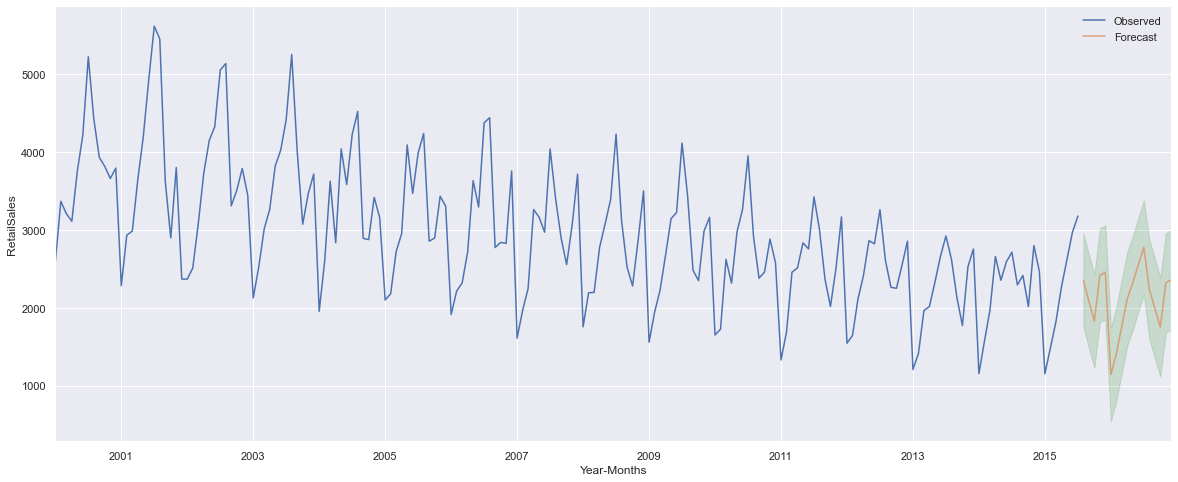

In [87]:
# plot the forecast along with the confidence band

axis = df['RetailSales'].plot(label='Observed')

pred_full_manual_SARIMA_data['mean'].plot(ax=axis, label='Forecast', alpha=0.7)

axis.fill_between(pred_full_manual_SARIMA_data.index, 
                  pred_full_manual_SARIMA_data['mean_ci_lower'], 
                  pred_full_manual_SARIMA_data['mean_ci_upper'], 
                  color='green', alpha=.15)

axis.set_xlabel('Year-Months')
axis.set_ylabel('RetailSales')
plt.legend(loc='best')
plt.show()

# END